# Universal differential equations

Esse notebook é uma demonstração de 'Universal differential equations' (UDE) usando modelos de circuitos equivalentes e PyBaMM. Uma UDE é uma equação diferencial definito, por todo ou em parte, em função de "aproximadores universais" (redes-neurais nesse caso).

Na prática, são sistema físicos, descritos por equações diferenciais, onde um dos componentes é uma rede neural[1]. Exemplo: $$\frac{\partial u}{\partial t} = f(x,u,t) + \mathcal{NN}(x,u)$$

Vantagem dessa implementação: $f(\cdot)$ pode ser um modelo físico simplificado (*reduced order*) que retorna uma mera aproximação do resultado real. Nesse caso, a rede neural $\mathcal{NN}$ pode ser menor, mais simples, responsável somente por corrigir o erro, a divergência.

---
1. Rackauckas et al 2021 (https://doi.org/10.48550/arXiv.2001.04385).

## Exemplo Neural-TECMD
O melhor exemplo, com código open-source disponível online, vem de Kuzhiyil et al, 2024 [2, 3]. O software é implementado em Julia, consegui faze-lo rodar localmente, mas não no Google Colab. Vou demonstrar abaixo a lógica básica do programa e o output do código -- não será possível executar localmente agora.

O artigo descreve o processo de combinar modelo  *Thermal Equivalent Circuit Model with Diffusion* (TECMD) -- um dos modelos do tipo ECM mais sofisticados -- com duas redes neurais que corrigem o erro de temperatura e tensão. Na figura abaixo, blocos pretos representam modelos físicos-matemáticos, blocos laranjas representam redes neurais.

![test](https://github.com/SarvTex/june_sciml_workshop/blob/main/imgs/neural_tecmd_kuzhiyil.jpg?raw=1)

O modelo conseguiu obter reduções de erro significativo, enquanto preserva performance.

A figura abaixo demonstra a comparação entre dados experimentais, e os resultados da simulação com e sem redes-neurais auxiliares.

![test](https://github.com/SarvTex/june_sciml_workshop/blob/main/imgs/neural_tecmd_plot.png?raw=1)

---
2. Kuzhiyil et al 2024 (https://doi.org/10.1016/j.apenergy.2024.123692)
3. https://github.com/JishnuKuzhiyil/Neural-TECMD-Battery-model

## Usando PyBaMM

Python Battery Mathematical Modelling (PyBaMM) é um pacote de Python open-source para simulação eletroquímica de baterias -- tipicamente a classe de modelos mais sofisticada e completa. Essa é uma ferramenta potencialmente muito útil dado nosso interesse em avaliação e diagnóstico de baterias por meio de modelos de simulação.

Durante essa demonstração inicial, vamos comparar um modelo ECM básico com o modelo eletroquímico DFN do PyBaMM.

#### Inicialização Colab
Caso esse notebook esteja sendo executado pelo Google Colab, algumas modificações tem que ser feitos. O bloco abaixo reorganiza esses aspectos.

In [1]:
# importing basic libs
import os
import sys

# setting up code to run in google colab
git_repo_url = "https://github.com/SarvTex/june_sciml_workshop.git"
repo_name = "june_sciml_workshop"

if 'google.colab' in sys.modules:
    # Google colab setup
    print("> Code running in Colab env ===")

    if not repo_name in os.getcwd().split(os.sep) and not repo_name in os.listdir():
        print("> Cloning repo (dataset) ===")
        !git clone {git_repo_url}
    else:
      print("> Repo already cloned ===")

    if repo_name in os.listdir():
        os.chdir(repo_name)
    print(f"> Currently in correct folder ({os.getcwd()}) ===")

else:
    # Running locally setup
    print("> Running locally. Assuming correct folder structure ===")

!ls

> Code running in Colab env ===
> Cloning repo (dataset) ===
Cloning into 'june_sciml_workshop'...
remote: Enumerating objects: 448, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (434/434), done.
remote: Total 448 (delta 18), reused 439 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (448/448), 37.76 MiB | 10.29 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (398/398), done.
> Currently in correct folder (/content/june_sciml_workshop) ===
01_pinnModel.ipynb		   data		       imgs
02_udeModel.ipynb		   enviroment.yml      README.md
03_physicsFeature_synthData.ipynb  explore_data.ipynb  test.ipynb


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
x = tf.zeros([2,2], dtype=tf.float32)
print(type(x))
print(x)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[0. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


In [36]:
class SimpleEquivalentCircuitModel(tf.keras.layers.Layer):
    """
    These are the model inputs:
        U_max | Max voltage
        U_min | Min voltage
        Ro | Internal resistance Ro
        ecm_nn | The neural net for correcting the physical model (pre-trained)
        soc_0 = 0.95, | Initial state of charge
        time_step = 10, | Time step
        units = 3, | Number of outputs/inner states
    """

    def __init__(self,
                 U_max:np.float32,
                 U_min:np.float32,
                 Ro:np.float32,
                 capacity:np.float32,
                 ecm_nn,
                 soc_0 = 0.95,
                 time_step = 10,
                 units = 2,
                 **kwargs):
        super(SimpleEquivalentCircuitModel, self).__init__(**kwargs)
        self.U0 = 0.5 * (U_max + U_min)
        self.dU = 0.5 * (U_max - U_min) * 0.2175
        self.Ro = Ro
        self.capacity = capacity
        self.soc_0 = soc_0
        self.dt = time_step
        self.ecm_nnet = ecm_nn
        # units
        self.state_size = tf.TensorShape(units)
        self.output_size = tf.TensorShape(units)

    def build(self, input_shape, **kwargs):
        self.built = True

    def v_out_phys(self, x_t):
        # x_t: inputs & state concat
        # x_t features: (curr, temp, v_out, soc)
        return self.U0 + self.dU * tf.math.log(x_t[:,3]/(1-x_t[:,3])) - self.Ro * x_t[:,0]

    def soc_phys(self, x_t):
        # coulomb counting:
        # dSoc/dt = -I/3600/C
        # x_t features: (curr, temp, v_out, soc)
        return x_t[:,3] - x_t[:,0] * self.dt / (3600 * self.capacity)


    def call(self, inputs, states):
        # input_t and output_{t-1}
        inputs = tf.convert_to_tensor(inputs) # should be a (x,2) tensor: [0] = current, [1] = temperature
        out_m1 = tf.convert_to_tensor(states) # should be a (x,2) tensor: [0] = v_out, [1] = soc
        x_t = tf.concat((inputs, out_m1[0,:]), axis=1)

        out = tf.stack([
            self.v_ocv_phys(x_t),
            self.soc_phys(x_t)
        ])
        out = out - self.ecm_nnet(x_t)
        return out, [out]


#### Explain

```python
    def call(self, inputs, states):
        # input_t and output_{t-1}
        inputs = tf.convert_to_tensor(inputs) # should be a (x,2) tensor: [0] = current, [1] = temperature
        out_m1 = tf.convert_to_tensor(states) # should be a (x,3) tensor: [0] = v_out, [1] = soc, [2] = v_rc
        x_t = tf.concat((inputs, out_m1[0,:]), axis=1)
```
Note: input should be a (x,2) tensor and states should be a list
which gets converted to a (1,x,3) tensor by the convert_to_tensor
method, hence this line

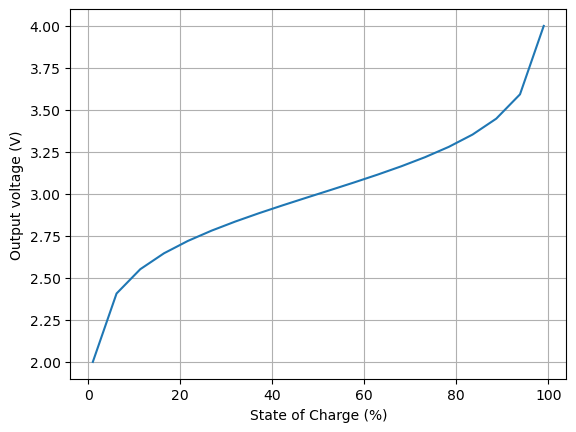

In [ ]:
1/4.595

0.2176278563656148

In [35]:
x1 = tf.convert_to_tensor([1,2,3], dtype=tf.float32)
x2 = tf.convert_to_tensor([4,5,6], dtype=tf.float32)

print(x1,x2)

print(tf.math.log(x1), "\n\n")

print(tf.stack((x1,x2)))

tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32) tf.Tensor([4. 5. 6.], shape=(3,), dtype=float32)
tf.Tensor([0.        0.6931472 1.0986123], shape=(3,), dtype=float32) 


tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
